#### Data Exploration: Investigate Data

In [11]:
%run './libraries.ipynb'

In [12]:
import pandas as pd
import random
import shelve

In [13]:
shared = shelve.open('.shared_vars')
dfRaw  = load_df("dfraw")
dfDesc = load_df("dfdesc")
dfFlt  = load_df("dfflt")


AttributeError: 'DbfilenameShelf' object has no attribute 'dfRaw'

In [4]:
list_todo()

todo,finished
Investigate 3298 null values in response_correctness,false
Investigate 1566 [unassigned] in response_correctness,false
Investigate null values in item_type_code_name,false
Reduce number of levels in item_type_code_name,false
"Remove unary learner_attempt_status = ""fully scored""",false
Investigate number_of_learners > 40 outliers,false
Investigate binary variables assignment_attempt_number and assignment_max_attempts,false
Investigate assignment_attempt_number and assignment_max_attempts both have 1566 values,false
"Investigate final_score_unweighted has 16,582 zero values",false
Replace default dates with nulls,false


In [5]:
dfInv = dfFlt

###### Remove variables assignment_late_submission, is_manual_scoring_required and is_deleted
Do this early so they don't get in the way

In [7]:
dfInv = dfInv.drop('assignment_late_submission', 'is_manual_scoring_required', 'is_deleted')
shared.binaryVars.remove('assignment_late_submission')
shared.binaryVars.remove('is_manual_scoring_required')
shared.binaryVars.remove('is_deleted')

In [8]:
finish_todo('Remove variables assignment_late_submission, is_manual_scoring_required and is_deleted')

###### Remove unary learner_attempt_status
Do this early so they don't get in the way

In [10]:
dfInv = dfInv.drop('learner_attempt_status')
nominalVars.remove('learner_attempt_status')

In [11]:
finish_todo('Remove unary learner_attempt_status = "fully scored"')

##### Investigate binary variables assignment_attempt_number and assignment_max_attempts
Appears binary but the variable name indicates it could have any values. The data only contains 1 and 0

In [13]:
dfPd = dfInv.toPandas()
# Return cross-tabulation table of assignment_attempt_number vs assignment_max_attempts adding counts for null values
pd.crosstab(dfPd.assignment_attempt_number.fillna('null'), dfPd.assignment_max_attempts.fillna('null'), margins=True, margins_name="Total")

assignment_max_attempts,0,1,Total
assignment_attempt_number,,,
0,1566,0,1566
1,0,78982,78982
Total,1566,78982,80548


- both fields only contain "0" 1566 out of 78,982 observations, otherwise the value is always "1"
- are they the same 1566 as the "[unassigned]" in response_correctness

In [15]:
dfZeroAttempt = dfInv.filter( F.col('assignment_attempt_number') == 0 )
cols = perfect_cor(dfZeroAttempt, "assignment_attempt_number")

dfZeroAttempt.select(*cols[:5]).show(1)
dfZeroAttempt.select(*cols[5:9]).show(1)
dfZeroAttempt.select(*cols[9:]).show(1)

+------------------+-----------------------+--------------------------------+---------------------+-------------------+
is_affecting_grade|assignment_max_attempts|assignment_final_submission_date|assignment_start_date|assignment_due_date|
+------------------+-----------------------+--------------------------------+---------------------+-------------------+
 true| 0| 2999-01-01 00:00:00| 1900-01-01 00:00:00|2999-01-01 00:00:00|
+------------------+-----------------------+--------------------------------+---------------------+-------------------+
only showing top 1 row

+---------------+----------------------+-----------------+--------------------+
is_force_scored|item_is_offline_scored|scoring_type_code|response_correctness|
+---------------+----------------------+-----------------+--------------------+
 false| false| [unassigned]| [unassigned]|
+---------------+----------------------+-----------------+--------------------+
only showing top 1 row

+--------------------+------+--------------------+
assigned_item_status|org_id| org_new|
+--------------------+------+--------------------+
 scored|360541|Philadelphia Schools|
+--------------------+------+--------------------+
only showing top 1 row

- scoring_type_code indicates it was manually scored
- what's the number of assessments

In [17]:
dfZeroAttempt.agg(
      F.countDistinct('section_id').alias('sections'), 
      F.countDistinct('learner_id').alias('learners'), 
      F.countDistinct('assessment_id').alias('assessments'), 
      F.countDistinct('assessment_item_response_id').alias('items'),
      F.sum( F.when( F.col('response_correctness')      == '[unassigned]', 1).otherwise(0)).alias('response_correctness'),
      F.sum( F.when( F.col('assignment_attempt_number') == 0, 1).otherwise(0)).alias('assignment_attempt_number'),
      F.sum( F.when( F.col('assignment_max_attempts')   == 0, 1).otherwise(0)).alias('assignment_max_attempts')
   ).show(1, False)

+--------+--------+-----------+-----+--------------------+-------------------------+-----------------------+
sections|learners|assessments|items|response_correctness|assignment_attempt_number|assignment_max_attempts|
+--------+--------+-----------+-----+--------------------+-------------------------+-----------------------+
5 |64 |12 |1566 |1566 |1566 |1566 |
+--------+--------+-----------+-----+--------------------+-------------------------+-----------------------+

In [18]:
finish_todo("Investigate binary variables assignment_attempt_number and assignment_max_attempts")

###### Investigate 1566 [unassigned] in response_correctness

In [20]:
dfPd = dfInv.toPandas()
# Return cross-tabulation table of assignment_attempt_number vs response_correctness adding counts for null values
pd.crosstab(dfPd.assignment_attempt_number.fillna('null'), dfPd.response_correctness.fillna('null'), margins=True, margins_name="Total")

response_correctness,[unassigned],correct,incorrect,null,partially_correct,Total
assignment_attempt_number,,,,,,
0,1566,0,0,0,0,1566
1,0,43761,30496,3298,1427,78982
Total,1566,43761,30496,3298,1427,80548


- 1566 response_correctness "[unassigned]" is the same observations as 1566 assignment_attempt_number and assignment_max_attempts
- investigate additonal correlations

In [22]:
dfUnassigned = dfInv.filter(F.col("response_correctness") == "[unassigned]")
cols = perfect_cor(dfUnassigned, "response_correctness")

dfUnassigned.select(*cols[:5]).show(1)
dfUnassigned.select(*cols[5:9]).show(1)
dfUnassigned.select(*cols[9:]).show(1)

+------------------+-----------------------+--------------------------------+---------------------+-------------------+
is_affecting_grade|assignment_max_attempts|assignment_final_submission_date|assignment_start_date|assignment_due_date|
+------------------+-----------------------+--------------------------------+---------------------+-------------------+
 true| 0| 2999-01-01 00:00:00| 1900-01-01 00:00:00|2999-01-01 00:00:00|
+------------------+-----------------------+--------------------------------+---------------------+-------------------+
only showing top 1 row

+-------------------------+---------------+----------------------+-----------------+
assignment_attempt_number|is_force_scored|item_is_offline_scored|scoring_type_code|
+-------------------------+---------------+----------------------+-----------------+
 0| false| false| [unassigned]|
+-------------------------+---------------+----------------------+-----------------+
only showing top 1 row

+--------------------+------+--------------------+
assigned_item_status|org_id| org_new|
+--------------------+------+--------------------+
 scored|360541|Philadelphia Schools|
+--------------------+------+--------------------+
only showing top 1 row

- each observation is
  - fully scored (learner_attempt_status = "fully scored")
  - same organization
  - has a score (unweighted_final_score varries, not included above)
  - assignment_attempt_number = 0 and assignment_max_attempts = 0 perfectly correlated

In [24]:
for f in intervalVars:
  if f not in ["assignment_final_submission_date", "assignment_start_date", "assignment_due_date"]:
    print (f)
    dfUnassigned.agg(
      F.countDistinct(f).alias("unique"), 
      F.count(F.when(F.col(f).isNull(), f)).alias("null"),
      F.min(f).alias("min"),
      F.max(f).alias("max")
   ).show(1, False)

max_student_stop_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
14 |0 |2019-09-10 14:44:06.405|2020-04-25 20:44:02.962|
+------+----+-----------------------+-----------------------+

min_student_start_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
14 |0 |2019-09-10 14:36:29.961|2020-04-01 01:22:00.607|
+------+----+-----------------------+-----------------------+

scored_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
161 |0 |2019-09-10 14:44:06.405|2020-04-25 20:44:02.962|
+------+----+-----------------------+-----------------------+

student_start_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
161 |0 |2019-09-10 14:36:29.961|2020-04-25 20:36:14.435|
+------+----+-----------------------+-----------------------+

student_stop_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
161 |0 |2019-09-10 14:44:06.405|2020-04-25 20:44:02.962|
+------+----+-----------------------+-----------------------+

was_fully_scored_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
161 |0 |2019-09-10 14:44:06.405|2020-04-25 20:44:02.962|
+------+----+-----------------------+-----------------------+

was_in_progress_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
161 |0 |2019-09-10 14:36:29.961|2020-04-25 20:36:14.435|
+------+----+-----------------------+-----------------------+

was_submitted_datetime_actual
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
161 |0 |2019-09-10 14:44:06.405|2020-04-25 20:44:02.962|
+------+----+-----------------------+-----------------------+

- dates spread among school year (9/10/2019 to 4/25/2020)
- max_student_start_datetime and max_student_stop_datetime have the same number of unique values (14)
  - these are entered by teacher
- remaining fields have the same number of unique values (161)

In [26]:
for f in identifierVars:
  print(f)
  dfUnassigned.agg(
    F.countDistinct(f).alias("unique"), 
    F.count(F.when(F.col(f).isNull(), f)).alias("null")
  ).show()

assessment_id
+------+----+
unique|null|
+------+----+
 12| 0|
+------+----+

assessment_instance_attempt_id
+------+----+
unique|null|
+------+----+
 161| 0|
+------+----+

assessment_instance_id
+------+----+
unique|null|
+------+----+
 14| 0|
+------+----+

assessment_item_response_id
+------+----+
unique|null|
+------+----+
 1566| 0|
+------+----+

learner_assigned_item_attempt_id
+------+----+
unique|null|
+------+----+
 1566| 0|
+------+----+

learner_assignment_attempt_id
+------+----+
unique|null|
+------+----+
 161| 0|
+------+----+

learner_id
+------+----+
unique|null|
+------+----+
 64| 0|
+------+----+

org_id
+------+----+
unique|null|
+------+----+
 1| 0|
+------+----+

section_id
+------+----+
unique|null|
+------+----+
 5| 0|
+------+----+

- all scores for one organization
  - 1 organization
  - 5 sections
  - 12 assessments
  - 14 assessment intances
    - 2 repeated
    - see datetime variables above with 161 values
  - 64 learners
  - 161 attempts
    - see datetime variables above with 161 values
  - 1566 questions

####### Conclusion: 1566 [unassigned] in response_correctness
- isolated to one organization
- no pattern, an outlier
- 1566 is 2% of observations
  - 1566 / 80548 
- remove 1566 rows
- binary variables assignment_attempt_number and assignment_max_attempts
  - will be unary after 1566 deleted
  - remove variables

In [29]:
finish_todo("Investigate 1566 [unassigned] in response_correctness")
finish_todo('Investigate assignment_attempt_number and assignment_max_attempts both have 1566 values')

In [30]:
# Make sure to preserve the nulls
dfInv = dfInv.filter(F.col("response_correctness").isNull() | (F.col("response_correctness") != "[unassigned]"))

In [31]:
dfInv = dfInv.drop("assignment_attempt_number", "assignment_max_attempts")

In [32]:
list_todo()

todo,finished
Investigate 3298 null values in response_correctness,false
Investigate 1566 [unassigned] in response_correctness,true
Investigate null values in item_type_code_name,false
Reduce number of levels in item_type_code_name,false
"Remove unary learner_attempt_status = ""fully scored""",true
Investigate number_of_learners > 40 outliers,false
Investigate binary variables assignment_attempt_number and assignment_max_attempts,true
Investigate assignment_attempt_number and assignment_max_attempts both have 1566 values,true
"Investigate final_score_unweighted has 16,582 zero values",false
Replace default dates with nulls,false


##### Investigate 3298 null values in response_correctness

- Check correlations
- Missing at random?

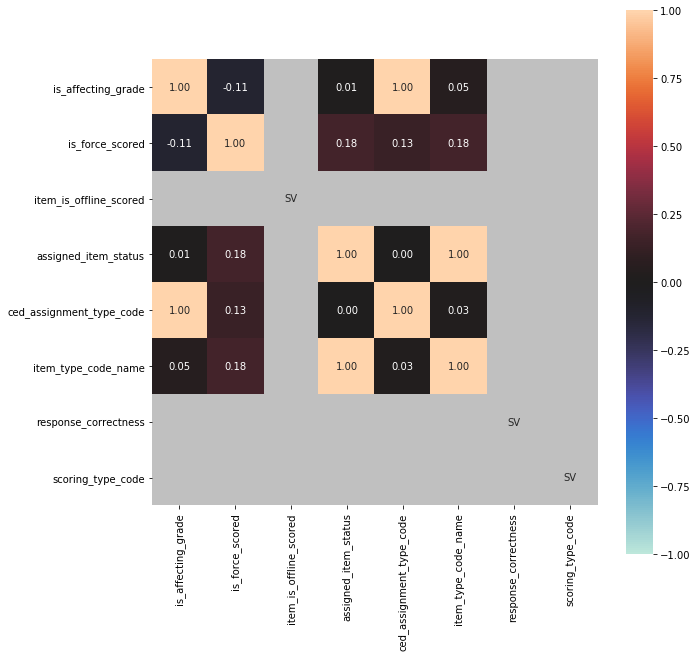

In [35]:
associations( dfFlt.filter(F.col('response_correctness').isNull() ).select(*binaryVars, *nominalVars).toPandas(), nan_replace_value='null', figsize=[10,10] )

- Single values
  - scoring_type_code
  - item_is_offline_scored
- Pefect correlation
  - is_affecting_grade & ced_assignment_type_code (previously existed)
  - assigned_item_status & item_type_code_name (previously existed)

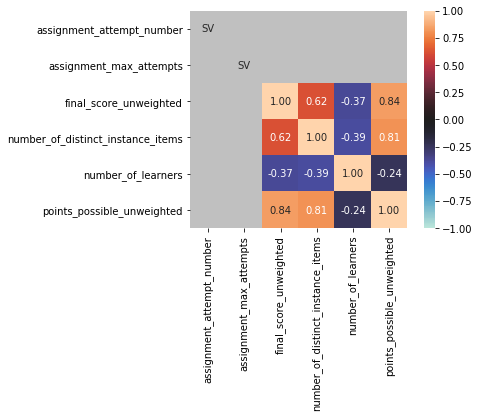

In [37]:
associations( dfFlt.filter(F.col('response_correctness').isNull() ).select(*continousVars).toPandas(), nan_replace_value='null' )

- Single values
  - assignment_attempt_number
  - assignment_max_attempts
- High Correlation
  - final_score_unweighted & points_possible_unweighted

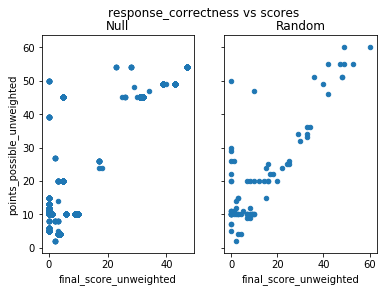

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

dfFlt.filter(F.col('response_correctness').isNull() ).toPandas().plot.scatter('final_score_unweighted', 'points_possible_unweighted', title='Null', ax=ax1)
dfFlt.sample(False, .001, 8764664).toPandas().plot.scatter('final_score_unweighted', 'points_possible_unweighted', title='Random', ax=ax2)
plt.suptitle('response_correctness vs scores')

plt.show()

- Null pattern similar to random

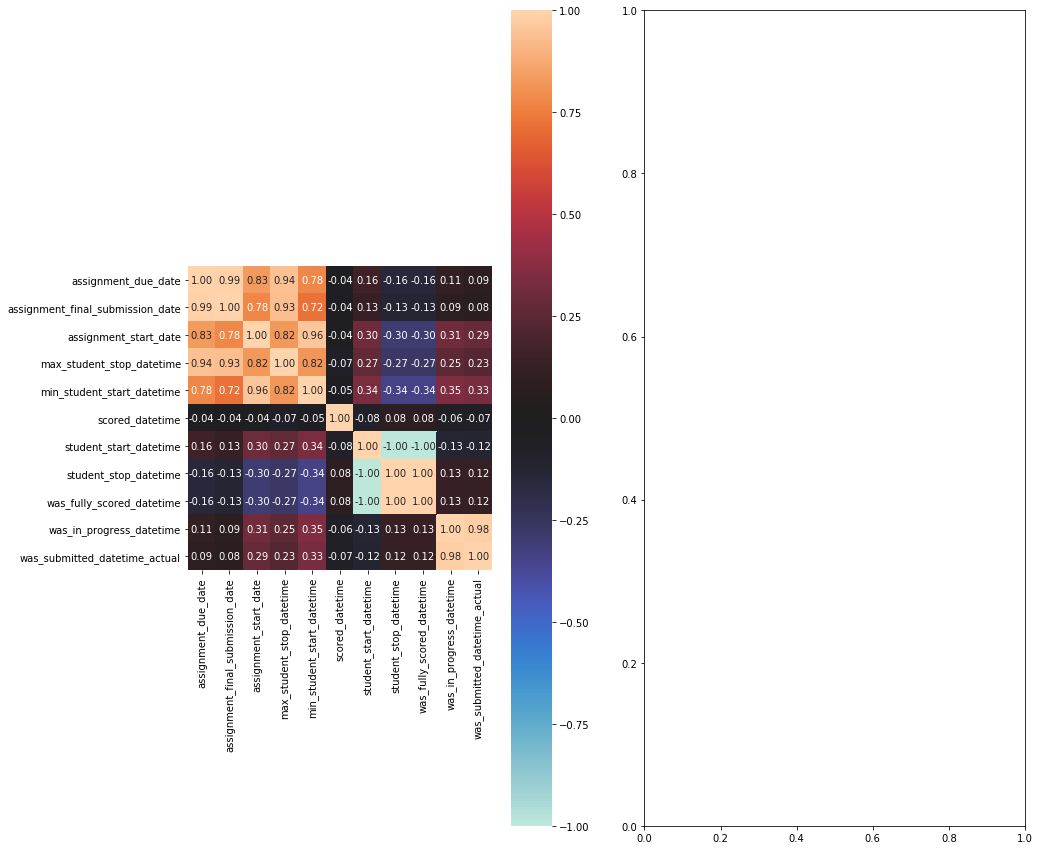

In [41]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

corr, ax1 = associations( dfFlt.filter(F.col('response_correctness').isNull() ).select(* (F.unix_timestamp(c).alias(c) for c in intervalVars) ).toPandas(), figsize=[10,10], ax=ax1 )

corr, ax2 = associations( dfFlt.select(* (F.unix_timestamp(c).alias(c) for c in intervalVars) ).toPandas(), ax=ax2 )
#plt.suptitle('response_correctness vs scores')

plt.show()



- New Strong correlations
  - max and min_student_stop_datetime & assignment_due_date
  - max and min_student_stop_datetime & assignment_final_submission_date

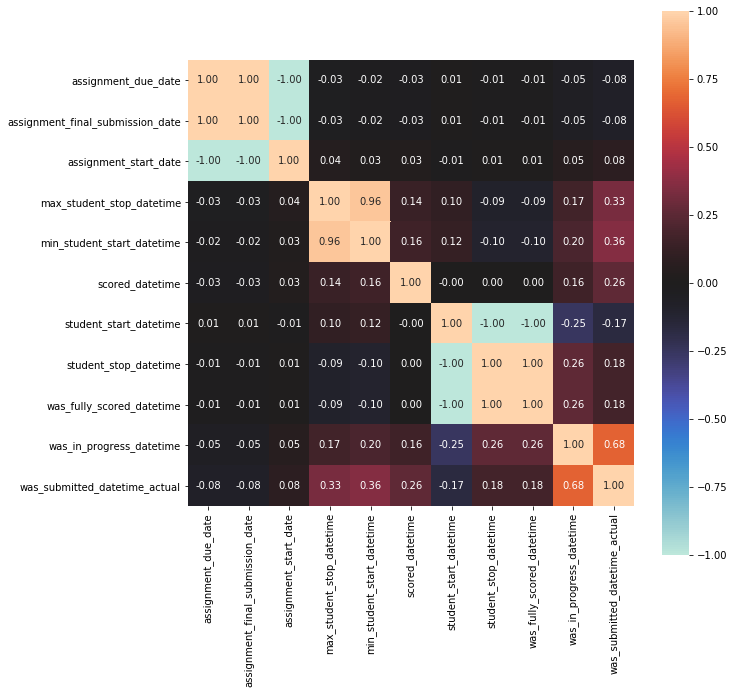

In [43]:
# Previous
associations( dfFlt.select(* (F.unix_timestamp(c).alias(c) for c in intervalVars) ).toPandas(), figsize=[10,10] )

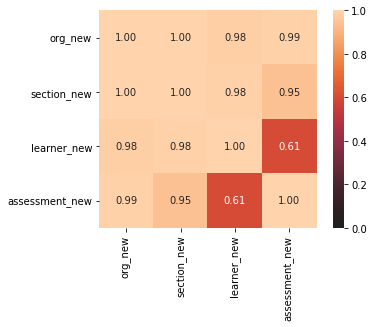

In [44]:
# null
associations( dfFlt.filter(F.col('response_correctness').isNull() ).select('org_new', 'section_new', 'learner_new', 'assessment_new').toPandas(), nan_replace_value='null' )

- Looking for single values
  - none found

In [46]:
def assoc_resp_cor():
  pdDf = dfInv.select('response_correctness','final_score_unweighted').toPandas()
  pdDf['final_score_unweighted'] = np.where(pdDf['final_score_unweighted'] == 0, 'zero', 'nonzero')

  return pd.crosstab(pdDf.final_score_unweighted.fillna('null'), pdDf.response_correctness.fillna('null'))
  
assoc_resp_cor()

response_correctness,correct,incorrect,null,partially_correct
final_score_unweighted,,,,
nonzero,42796,17434,794,1386
zero,965,13062,2504,41


- response_correctness = 'correct' when score is nonzero
- impute response_correctness based on final_score_unweighted with median
  - final_score_unweighted is right skewed
  -

In [48]:
def score_by_correct():
  pdDf = dfInv.select('response_correctness','final_score_unweighted').toPandas()
  return pdDf.groupby('response_correctness')[['final_score_unweighted']].median()

score_by_correct()

,final_score_unweighted
response_correctness,
correct,12
incorrect,2
partially_correct,13


In [49]:
# +--------------------+-----+
# |response_correctness|count|
# +--------------------+-----+
# |correct             |43761|
# |incorrect           |30496|
# |null                |3298 |
# |[unassigned]        |1566 |
# |partially_correct   |1427 |
# +--------------------+-----+

pdDf = dfFlt.select('response_correctness', 'final_score_unweighted').toPandas()
pdDf[ pdDf['response_correctness'] == 'correct']['final_score_unweighted'].median()
pdDf[ pdDf['response_correctness'] == 'incorrect']['final_score_unweighted'].median()


Out[111]: 2.0

In [50]:

# Bin the data frame by "a" with 10 bins...
bins = np.linspace(pdDf.final_score_unweighted.min(), pdDf.final_score_unweighted.max(), 10)
groups = pdDf.groupby(pd.cut(pdDf.final_score_unweighted, bins))
groups

Out[113]: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7ff518043a50>

In [51]:
  spark.sql("SELECT source, percentile_approx(value, 0.5) FROM raw_data GROUP BY source")

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-3759530615091907> in <module> 
 ----> 1 spark . sql ( "SELECT source, percentile_approx(value, 0.5) FROM raw_data GROUP BY source" ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 702 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 703 """
 --> 704 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 705 
 706 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 132 # Hide where the exception came from that shows a non-Pythonic 
 133 # JVM exception message. 
 --> 134 raise_from ( converted ) 
 135 else : 
 136 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : Table or view not found: raw_data; line 1 pos 50;
'Aggregate ['source], ['source, unresolvedalias('percentile_approx('value, 0.5), None)]
+- 'UnresolvedRelation [raw_data]

- Single values
  - item_is_offline_scored
  - scoring_type_code
- Correlations
  - is_affecting_grade & ced_assignment_type_code
  - assigned_item_status & item_type_code_name

In [54]:
dfInv.filter(F.col("response_correctness").isNull() == True).select('item_is_offline_scored', 'scoring_type_code', 'is_affecting_grade', 'ced_assignment_type_code', 'assigned_item_status', 'item_type_code_name').distinct().show()


+----------------------+-----------------+------------------+------------------------+--------------------+-------------------+
item_is_offline_scored|scoring_type_code|is_affecting_grade|ced_assignment_type_code|assigned_item_status|item_type_code_name|
+----------------------+-----------------+------------------+------------------------+--------------------+-------------------+
 false| [unassigned]| false| practice| responded| essay|
 false| [unassigned]| true| assessment| responded| essay|
 false| [unassigned]| false| practice| assigned| null|
 false| [unassigned]| true| assessment| assigned| null|
 false| [unassigned]| true| clo| assigned| null|
 false| [unassigned]| true| assessment| responded| shortAnswer|
+----------------------+-----------------+------------------+------------------------+--------------------+-------------------+

Explanation Null values in response_correctness Perfect Correlations
- response_correctness is null when not scored (scoring_type_code = '[unassigned]')
  - manually scorred
- contridicts item_is_offline_scored = false
  - automatically scorred
- All perfectly correlated fields appear to be default values when not scorred

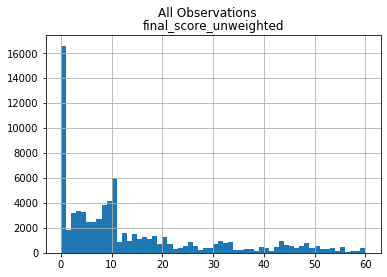

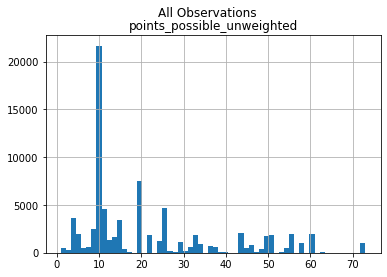

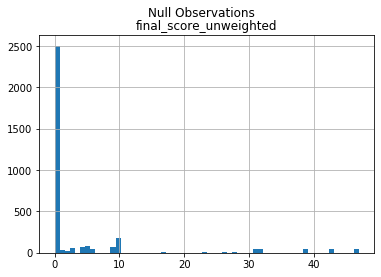

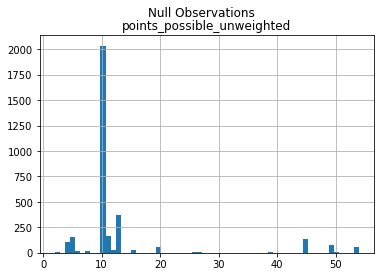

In [56]:
def null_stats():
  dfNull = dfInv.filter(F.col("response_correctness").isNull() == True)
  
  dfInv.select('final_score_unweighted').toPandas().hist(bins=60)
  plt.suptitle('All Observations')
  plt.title('final_score_unweighted')
  
  dfInv.select("points_possible_unweighted").toPandas().hist(bins=60)
  plt.suptitle('All Observations')
  plt.title('points_possible_unweighted')

  dfNull.select("final_score_unweighted").toPandas().hist(bins=60)
  plt.suptitle('Null Observations')
  plt.title('final_score_unweighted')

  dfNull.select("points_possible_unweighted").toPandas().hist(bins=60)
  plt.suptitle('Null Observations')
  plt.title('points_possible_unweighted')


null_stats()

- closely correlated with final_score_unweighted = 0

In [58]:
finish_todo('Investigate 3298 null values in response_correctness')

##### Investigate null values in item_type_code_name

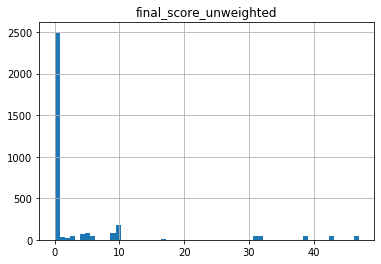

In [60]:
dfInv.filter(F.col("item_type_code_name").isNull() == True).select("final_score_unweighted").toPandas().hist(bins=60)

- Strongly correlated to a final_score_unweighted of 0

In [62]:
finish_todo('Investigate null values in item_type_code_name')

In [63]:
list_todo()

todo,finished
Investigate 3298 null values in response_correctness,true
Investigate 1566 [unassigned] in response_correctness,true
Investigate null values in item_type_code_name,true
Reduce number of levels in item_type_code_name,false
"Remove unary learner_attempt_status = ""fully scored""",true
Investigate number_of_learners > 40 outliers,false
Investigate binary variables assignment_attempt_number and assignment_max_attempts,true
Investigate assignment_attempt_number and assignment_max_attempts both have 1566 values,true
"Investigate final_score_unweighted has 16,582 zero values",false
Replace default dates with nulls,false


##### Investigate null values in item_type_code_name

In [65]:
pdDf = dfInv.toPandas()
pd.crosstab(pdDf.learner_attempt_status.fillna('null'), pdDf.response_correctness.fillna('null'),)

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-3883230318352899> in <module> 
 1 pdDf = dfInv . toPandas ( ) 
 ----> 2 pd . crosstab ( pdDf . learner_attempt_status . fillna ( 'null' ) , pdDf . response_correctness . fillna ( 'null' ) , ) 

 /databricks/python/lib/python3.7/site-packages/pandas/core/generic.py in __getattr__ (self, name) 
 5272 if self . _info_axis . _can_hold_identifiers_and_holds_name ( name ) : 
 5273 return self [ name ] 
 -> 5274 return object . __getattribute__ ( self , name ) 
 5275 
 5276 def __setattr__ ( self , name : str , value ) -> None : 

 AttributeError : 'DataFrame' object has no attribute 'learner_attempt_status'

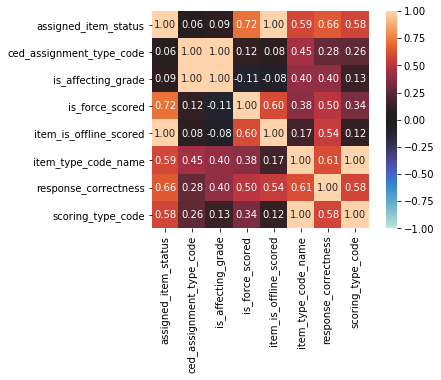

In [66]:
def testing():
  cols = ['assigned_item_status', 'ced_assignment_type_code', 'is_affecting_grade', 'is_force_scored', 'item_is_offline_scored', 'item_type_code_name',  'response_correctness', 'scoring_type_code']
  pdDf = dfInv.select(*cols).toPandas()
  # Plot features associations
  associations(pdDf)
  
testing()

In [67]:
pdDf = dfInv.toPandas()
pd.crosstab(pdDf.assigned_item_status.fillna('null'),     pdDf.item_is_offline_scored.fillna('null'))

item_is_offline_scored,False,True
assigned_item_status,,
assigned,3264,0
offline_scored,0,12446
responded,34,0
scored,63238,0


In [68]:
pd.crosstab(pdDf.ced_assignment_type_code.fillna('null'), pdDf.is_affecting_grade.fillna('null'))

is_affecting_grade,False,True
ced_assignment_type_code,,
assessment,0,76172
clo,0,248
practice,2562,0


In [69]:
pd.crosstab(pdDf.item_type_code_name.fillna('null'), pdDf.scoring_type_code.fillna('null'))

scoring_type_code,[unassigned],automatic,external,manual
item_type_code_name,,,,
aheAlgo,0,0,219,0
bucketing,0,1051,0,0
choiceMatrix,0,1336,0,0
cloze,0,3576,0,0
equationEntry,0,9516,0,0
essay,9,0,0,991
fileUpload,0,0,0,49
fillInTheBlank,0,12072,0,0
graphing,0,2415,0,0


In [70]:
# Count the number of each response_correctness level where the final_score_unweighted is 0
dfInv.filter(col("final_score_unweighted") == 0).groupBy("response_correctness").count().orderBy("count", ascending=False).show(50, False)

+--------------------+-----+
response_correctness|count|
+--------------------+-----+
null |59631|
incorrect |17981|
correct |5485 |
partially_correct |572 |
[unassigned] |10 |
+--------------------+-----+

- final_score_unweighted be used to predict response_correctness
  - no
- is response_correctness null or incorrect if final_score_unweighted is 0
  - no

Are the following related?
- assignment_due_date, assignment_final_submission_date and assignment_start_date have 1566 empty dates
- assignment_attempt_number and assignment_max_attempts have 1566 records with the value 0
- there are 1566 records with the response_correctness "[unassigned]"

In [73]:
import pandas as pd

dfPd = dfInv.toPandas()
# Return cross-tabulation table of learner_attempt_status vs response_correctness adding counts for null values
pd.crosstab(dfPd.learner_attempt_status.fillna('null'), dfPd.response_correctness.fillna('null'), margins=True, margins_name="Total")

response_correctness,[unassigned],correct,incorrect,null,partially_correct,Total
learner_attempt_status,,,,,,
assigned,0,671,214,41099,26,42010
awaiting outcome,0,2807,1636,9905,392,14740
fully scored,1566,43761,30496,3298,1427,80548
in progress,0,2224,3383,6745,157,12509
Total,1566,49463,35729,61047,2002,149807


In [74]:
# Return cross-tabulation table of learner_attempt_status vs assigned_item_status adding counts for null values
pd.crosstab(dfPd.learner_attempt_status.fillna('null'), dfPd.assigned_item_status.fillna('null'), margins=True, margins_name="Total")

assigned_item_status,assigned,delivered,offline_scored,responded,scored,Total
learner_attempt_status,,,,,,
assigned,41065,0,6,34,905,42010
awaiting outcome,7541,79,2,2285,4833,14740
fully scored,3264,0,12446,34,64804,80548
in progress,5875,383,22,487,5742,12509
Total,57745,462,12476,2840,76284,149807


In [75]:
# Return cross-tabulation table of learner_attempt_status vs scoring_type_code adding counts for null values
pd.crosstab(dfPd.learner_attempt_status.fillna('null'), dfPd.scoring_type_code.fillna('null'), margins=True, margins_name="Total")

scoring_type_code,[unassigned],automatic,external,manual,Total
learner_attempt_status,,,,,
assigned,41099,809,0,102,42010
awaiting outcome,9905,4835,0,0,14740
fully scored,4864,73467,219,1998,80548
in progress,6745,5742,9,13,12509
Total,62613,84853,228,2113,149807


In [76]:
from pyspark.sql.functions import unix_timestamp, col
import seaborn as sn
import matplotlib.pyplot as plt

dfPd =  filter_default(dfInv).select(* (unix_timestamp(c).alias(c) for c in intervalVars) ).toPandas()

corrMatrix = dfPd.corr()
plt.figure(figsize=(10,12))
sn.heatmap(corrMatrix, annot=True)
plt.show()


--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-1125508361365743> in <module> 
 3 import matplotlib . pyplot as plt
 4 
 ----> 5 dfPd = filter_default ( dfRaw ) . select ( * ( unix_timestamp ( c ) . alias ( c ) for c in intervalFields ) ) . toPandas ( ) 
 6 
 7 corrMatrix = dfPd . corr ( ) 

 TypeError : filter_default() missing 2 required positional arguments: 'f1' and 'f2'

Interval Correlation Results
- Perfectly correlated (1 or -1)
  - assignment_due_date and..
    - assignment_final_submission_date
    - assignment_start_date
    - Comments: Verify and possibly use only one
- Highly correlated (> .7)
  - max_student_start_datetime and min_student_stop_datetime
    - Explanation: quizes are short and ending always follows starting
  - scored_datetime and..
    - student_stop_datetime
    - was_fully_scored_datetime
    - was_submitted_datetime_actual
    - Explanation: actions closely follow stopping
  - student_start_datetime and..
    - student_stop_datetime
    - was_inprogress_datetime
    - Explanation: quizes are short and ending always follows starting
  - student_stop_datetime and..
    - scored_datetime
    - student_start_datetime
    - was_fully_scored_datetime
    - Explanation: quizes are short and ending always follows starting

In [78]:
date_stats(dfInv, "assignment_due_date", "assignment_final_submission_date").describe().show()


+-------+-------------------+------------------+-------------------+
summary| days| hours| minues|
+-------+-------------------+------------------+-------------------+
 count| 148241| 148241| 148241|
 mean|-0.7467097496643978|-17.92103399194555|-1075.2620395167328|
 stddev| 5.149168204745133|123.58003691388323| 7414.802214832992|
 min| -52.0| -1248.0| -74880.0|
 max| 0.0| 0.0| 0.0|
+-------+-------------------+------------------+-------------------+

# Investigations

### Is learner_attempt_status of "fully scored" perfectly correlated other variables

In [81]:
cols = perfect_cor(dfClean, "learner_attempt_status")
print("Correlated Vars", cols)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365756> in <module> 
 ----> 1 cols = perfect_cor ( dfClean , "learner_attempt_status" ) 
 2 print ( "Correlated Vars" , cols ) 

 NameError : name 'dfClean' is not defined

- No

In [83]:
df = dfClean.filter(col("assignment_due_date").isNull() == True)
cols = perfect_cor(df, "assignment_due_date")

# Show the results on two lines
length = len(cols)
middle_index = length//2
first_half = cols[:middle_index]
second_half = cols[middle_index:]

df.select(*first_half).show(1)
df.select(*second_half).show(1)



--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365763> in <module> 
 ----> 1 df = dfClean . filter ( col ( "assignment_due_date" ) . isNull ( ) == True ) 
 2 cols = perfect_cor ( df , "assignment_due_date" ) 
 3 
 4 # Show the results on two lines 
 5 length = len ( cols ) 

 NameError : name 'dfClean' is not defined

Yes they are all related
- only occurs in one organization
- could be record keeping differences
- EXCLUDE?

### Why Are Empty Dates Empty

In [86]:
from pyspark.sql.functions import count, col
# Count Default / Empty Dates

for f in intervalVars:
  count = dfClean.filter(col(f).isNull() == True).count()
  print (f,"=", count)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365766> in <module> 
 3 
 4 for f in intervalFields : 
 ----> 5 count = dfClean . filter ( col ( f ) . isNull ( ) == True ) . count ( ) 
 6 print ( f , "=" , count ) 

 NameError : name 'dfClean' is not defined

In [87]:
df = dfClean.filter(col("scored_datetime").isNull() == True)
cols = perfect_cor(df, "scored_datetime")
df.select(*cols).show(1)


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365767> in <module> 
 ----> 1 df = dfClean . filter ( col ( "scored_datetime" ) . isNull ( ) == True ) 
 2 cols = perfect_cor ( df , "scored_datetime" ) 
 3 df . select ( * cols ) . show ( 1 ) 

 NameError : name 'dfClean' is not defined

scored_datetime is null at times when fully scored

In [89]:
import math

df = dfClean.filter(col("student_start_datetime").isNull() == True)
cols = perfect_cor(df, "student_start_datetime")

# Show the results on two lines

df.select(*cols[:5]).show(1)
df.select(*cols[5:9]).show(1)
df.select(*cols[9:]).show(1)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365769> in <module> 
 1 import math
 2 
 ----> 3 df = dfClean . filter ( col ( "student_start_datetime" ) . isNull ( ) == True ) 
 4 cols = perfect_cor ( df , "student_start_datetime" ) 
 5 

 NameError : name 'dfClean' is not defined

- Null for one organization
- Could just be record keeping difference

In [91]:
df = dfClean.filter(col("was_in_progress_datetime").isNull() == True)
cols = perfect_cor(df, "was_in_progress_datetime")
df.select(*cols).show(1)


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365771> in <module> 
 ----> 1 df = dfClean . filter ( col ( "was_in_progress_datetime" ) . isNull ( ) == True ) 
 2 cols = perfect_cor ( df , "was_in_progress_datetime" ) 
 3 df . select ( * cols ) . show ( 1 ) 

 NameError : name 'dfClean' is not defined

- Only when fully scored

In [93]:
df = dfClean.filter(col("was_submitted_datetime_actual").isNull() == True)
cols = perfect_cor(df, "was_submitted_datetime_actual")
df.select(*cols).show(1)


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365773> in <module> 
 ----> 1 df = dfClean . filter ( col ( "was_submitted_datetime_actual" ) . isNull ( ) == True ) 
 2 cols = perfect_cor ( df , "was_submitted_datetime_actual" ) 
 3 df . select ( * cols ) . show ( 1 ) 

 NameError : name 'dfClean' is not defined

- Only when fully scored

### Reclassify categories in item_type_code_name

In [96]:
# Before Categories
dfClean.select("item_type_code_name").distinct().orderBy("item_type_code_name").show(50, False)


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365776> in <module> 
 1 # Before Categories 
 ----> 2 dfClean . select ( "item_type_code_name" ) . distinct ( ) . orderBy ( "item_type_code_name" ) . show ( 50 , False ) 

 NameError : name 'dfClean' is not defined

Combine Suffix Levels
- The levels with the suffix Response (ex: FillinBlankResponse) is the same type of question as level without the suffix (ex: fillInTheBlank)

In [98]:
# Combine fillInTheBlank and FillinBlankResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "FillinBlankResponse", "fillInTheBlank" ).otherwise(col("item_type_code_name")) )

# Combine multipleChoice and MultipleChoiceResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "MultipleChoiceResponse", "multipleChoice" ).otherwise(col("item_type_code_name")) )


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1125508361365778> in <module> 
 1 # Combine fillInTheBlank and FillinBlankResponse 
 ----> 2 dfClean = dfClean . withColumn ( "item_type_code_name" , when ( col ( "item_type_code_name" ) == "FillinBlankResponse" , "fillInTheBlank" ) . otherwise ( col ( "item_type_code_name" ) ) ) 
 3 
 4 # Combine multipleChoice and MultipleChoiceResponse 
 5 dfClean = dfClean . withColumn ( "item_type_code_name" , when ( col ( "item_type_code_name" ) == "MultipleChoiceResponse" , "multipleChoice" ) . otherwise ( col ( "item_type_code_name" ) ) ) 

 NameError : name 'dfClean' is not defined

In [99]:
%sql
select assessment_instance_id, 
 section_id,
 assessment_instance_attempt_id,
 assignment_start_date
FROM clean_data
WHERE assessment_instance_attempt_id IS NOT NULL
ORDER BY assessment_instance_id, assessment_instance_attempt_id, student_start_datetime LIMIT 100
;

com.databricks.backend.common.rpc.DatabricksExceptions$SQLExecutionException: org.apache.spark.sql.AnalysisException: Table or view not found: clean_data; line 5 pos 5;
'GlobalLimit 100
+- 'LocalLimit 100
 +- 'Sort ['assessment_instance_id ASC NULLS FIRST, 'assessment_instance_attempt_id ASC NULLS FIRST, 'student_start_datetime ASC NULLS FIRST], true
 +- 'Project ['assessment_instance_id, 'section_id, 'assessment_instance_attempt_id, 'assignment_start_date]
 +- 'Filter isnotnull('assessment_instance_attempt_id)
 +- 'UnresolvedRelation [clean_data]

	at org.apache.spark.sql.catalyst.analysis.package$AnalysisErrorAt.failAnalysis(package.scala:42)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.$anonfun$checkAnalysis$1(CheckAnalysis.scala:109)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.$anonfun$checkAnalysis$1$adapted(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:184)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.checkAnalysis(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.checkAnalysis$(CheckAnalysis.scala:92)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.checkAnalysis(Analyzer.scala:136)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:164)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:201)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:161)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:90)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:162)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:828)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:162)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:90)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:88)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:80)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:102)
	at org.apache.spark.sql.SparkSession.withActi

The assignment start date is the same for every assessment_instance_id.  Looks like it's assigned with the instance is created

In [101]:
%sql
SELECT COUNT(*) FROM clean_data WHERE assignment_start_date IS NULL;

com.databricks.backend.common.rpc.DatabricksExceptions$SQLExecutionException: org.apache.spark.sql.AnalysisException: Table or view not found: clean_data; line 1 pos 21;
'Aggregate [unresolvedalias(count(1), None)]
+- 'Filter isnull('assignment_start_date)
 +- 'UnresolvedRelation [clean_data]

	at org.apache.spark.sql.catalyst.analysis.package$AnalysisErrorAt.failAnalysis(package.scala:42)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.$anonfun$checkAnalysis$1(CheckAnalysis.scala:109)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.$anonfun$checkAnalysis$1$adapted(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:184)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$foreachUp$1$adapted(TreeNode.scala:183)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:183)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.checkAnalysis(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.checkAnalysis$(CheckAnalysis.scala:92)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.checkAnalysis(Analyzer.scala:136)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:164)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:201)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:161)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:90)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:162)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:828)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:162)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:90)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:88)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:80)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:102)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:828)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:100)
	at org.apache.spark.sql.SparkSession.$anonfun$sql$1(SparkSession.scala:663)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:828)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:658)
	at org.apache.spark.sql.SQLContext.sql(SQLContext.scala:672)
	at com.databricks.backend.daemon.driver.SQLDriverLocal.$anonfun$executeSql$1(SQLDriverLocal.scala:88)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at scala.collection.immutable.List.map(List.scala:298)
	at com.databricks.backend.daemon.driver.SQLDriverLocal.executeSql(SQLDriverLocal.scala:34)
	at com.databricks.backend.daemon.driver.SQLDriverLocal.repl(SQLDriverLocal.scala:141)
	at com.databricks.backend.daemon.driver.DriverLocal.$anonfun$execute$10(DriverLocal.scala:396)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:238)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	

Hmm... there's that 1566 again.  Let's look at those records

In [103]:
dfDesc.select('field').show(40, False)

+---------------------------------+
field |
+---------------------------------+
assessment_id |
assessment_instance_attempt_id |
assessment_instance_id |
assessment_item_response_id |
assigned_item_status |
assignment_attempt_number |
assignment_due_date |
assignment_final_submission_date |
assignment_late_submission |
assignment_max_attempts |
assignment_start_date |
ced_assignment_type_code |
final_score_unweighted |
is_affecting_grade |
is_deleted |
is_force_scored |
is_manual_scoring_required |
item_is_offline_scored |
item_type_code_name |
learner_assigned_item_attempt_id |
learner_assignment_attempt_id |
learner_attempt_status |
learner_id |
max_student_stop_datetime |
min_student_start_datetime |
number_of_distinct_instance_items|
number_of_learners |
org_id |
points_possible_unweighted |
response_correctness |
scored_datetime |
scoring_type_code |
section_id |
student_start_datetime |
student_stop_datetime |
was_fully_scored_datetime |
was_in_progress_datetime |
was_submitted_datetime_actual |
+---------------------------------+

In [ ]:
shared.close()
save_df(todoList, "todolist")
save_df(dfInv, "dfinv")